# Recommending Movies

-------------------------------------------------

The raw code for this Jupyter notebook is by default hidden for easier reading. The main focus of this particular page of the notebook is on the graphs and their interpretation. To toggle on/off the raw code, click below:

In [1]:
# Setup Code toggle button
from IPython.core.display import HTML  

HTML(''' 
<center><h3>
<a href="javascript:code_toggle()">Talk is cheap, show me the code.</a>
</center></h3>
<script>
    var code_show=true; //true -> hide code at first

    function code_toggle() {
        $('div.prompt').hide(); // always hide prompt

        if (code_show){
            $('div.input').hide();
        } else {
            $('div.input').show();
        }
        code_show = !code_show
    }
    $( document ).ready(code_toggle);
</script>
''')

In [2]:
# Setup notebook theme
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme(get_themes()[1])

In [3]:
# Load R magic
%load_ext rpy2.ipython

&nbsp;

## Get the Dataset

This time we are skipping Python and going streight into R. The data is provided in tab seperated files which can easily be read into an R dataframe. Unfortuantely Python dataframes print with infinitly better formatting than R though. It makes the data much easier to inspect.

#### `u.user`

&nbsp;

In [4]:
%%R

library(knitr)

u.user <- read.delim("../data/u.user",
                     sep="|",
                     header=FALSE,
                     col.names=c("user.id", "age", "gender", "occupation", "zip.code")
                    )

kable(head(u.user), format='rst')



=======  ===  ======  ==========  ========
user.id  age  gender  occupation  zip.code
=======  ===  ======  ==========  ========
      1   24  M       technician  85711   
      2   53  F       other       94043   
      3   23  M       writer      32067   
      4   24  M       technician  43537   
      5   33  F       other       15213   
      6   42  M       executive   98101   
=======  ===  ======  ==========  ========


&nbsp;

#### `u.data`

&nbsp;

In [5]:
%%R

u.data <- read.delim("../data/u.data",
                     sep="\t",
                     header=FALSE,
                     col.names=c("user.id", "item.id", "rating", "timestamp")
                    )

kable(head(u.data), format='rst')



=======  =======  ======  =========
user.id  item.id  rating  timestamp
=======  =======  ======  =========
    196      242       3  881250949
    186      302       3  891717742
     22      377       1  878887116
    244       51       2  880606923
    166      346       1  886397596
    298      474       4  884182806
=======  =======  ======  =========


&nbsp;

#### `u.item`

Sometimes no matter how hard you try R will just always be ugly...

&nbsp;

In [6]:
%%R

u.item <- read.delim("../data/u.item",
                     sep="|",
                     header=FALSE,
                     col.names=c("movie.id", "movie.title", "release.date",
                                 "video.release.date", "IMDB.URL", "unknown",
                                 "action", "adventure", "animation", "children",
                                 "comedy", "crime", "documentary", "drama",
                                 "fantasy", "film-noir", "horror", "musical",
                                 "mystery", "romance", "sci-fi", "thriller",
                                 "war", "western"
                                )
                    )

head(u.item)

  movie.id                                          movie.title release.date
1        1                                     Toy Story (1995)  01-Jan-1995
2        2                                     GoldenEye (1995)  01-Jan-1995
3        3                                    Four Rooms (1995)  01-Jan-1995
4        4                                    Get Shorty (1995)  01-Jan-1995
5        5                                       Copycat (1995)  01-Jan-1995
6        6 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)  01-Jan-1995
  video.release.date
1                 NA
2                 NA
3                 NA
4                 NA
5                 NA
6                 NA
                                                      IMDB.URL unknown action
1        http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)       0      0
2          http://us.imdb.com/M/title-exact?GoldenEye%20(1995)       0      1
3       http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)       0      0
4 

&nbsp;

## Find the 3 users who are closest to you

Using the metrics:

*  age
*  gender
*  occupation

Dataframes can be subsetted based on values in each row (column values) using the pattern:

```R
dataframe[ dataframe$column.id == x, ]
```

&nbsp;

In [7]:
%%R

df <- u.user[ u.user$age == 29 & u.user$gender == 'M' & u.user$occupation == 'programmer', ]
kable(df, format='rst')



===  =======  ===  ======  ==========  ========
\    user.id  age  gender  occupation  zip.code
===  =======  ===  ======  ==========  ========
45        45   29  M       programmer  50233   
222      222   29  M       programmer  27502   
===  =======  ===  ======  ==========  ========


&nbsp;

Only two hits, lets throw in a scientist then.

&nbsp;

In [8]:
%%R

df <- u.user[ u.user$age == 29 & u.user$gender == 'M' & u.user$occupation == 'scientist', ]
kable(df, format='rst')



===  =======  ===  ======  ==========  ========
\    user.id  age  gender  occupation  zip.code
===  =======  ===  ======  ==========  ========
483      483   29  M       scientist   43212   
===  =======  ===  ======  ==========  ========


&nbsp;

Users 45, 222, and 483 it is.

&nbsp;
### Get the individual user data

To do this we just need to subset the `u.data` dataframe the same way we did for the `u.user` dataframe to pull out the users with a similar gender, age, and occupation. Because we can name each new user dataframe something like `u#.data` we also do not need the information in the `user.id` or `timestamp` columns.

#### `user 45`

In [9]:
%%R

u45.data <- u.data[ u.data$user.id == 45, ][c("item.id", "rating")]
rownames(u45.data) <- 1:nrow(u45.data)
kable(head(u45.data), format='rst')



=======  ======
item.id  rating
=======  ======
     25       4
    109       5
    118       4
    763       2
    473       3
    472       3
=======  ======


&nbsp;

#### `user 222`

In [10]:
%%R

u222.data <- u.data[ u.data$user.id == 222, ][c("item.id", "rating")]
rownames(u222.data) <- 1:nrow(u222.data)
kable(head(u222.data), format='rst')



=======  ======
item.id  rating
=======  ======
    366       4
    750       5
    755       4
    118       4
     77       4
    724       3
=======  ======


&nbsp;

#### `user 483`

In [11]:
%%R

u483.data <- u.data[ u.data$user.id == 483, ][c("item.id", "rating")]
rownames(u483.data) <- 1:nrow(u483.data)
kable(head(u483.data), format='rst')



=======  ======
item.id  rating
=======  ======
    237       3
    144       2
    181       4
    900       3
    462       3
    250       3
=======  ======


&nbsp;

### Get the `movie.id` for each `item.id`

To do this we need to make a list of `(movie, rating)` pairs for each user. This will require the data from the indiviual `u.data` dataframe and the `u.item` dataframe. Each `u.data` dataframe contains an `item.id` which coresponds to a `movie.id` in the `u.item` data and a `rating`. Pythonista Pseudo code would look like:

    for item.id, rating in u.data:
        movie = u.item['item.id']
        add movie, rating to user.movies

Then from movies ratings that stand out as particularly resonating with me as good or bad the score will be calculated as:

$$
\text{# of good rates} - \text{# of bad rates}
$$

&nbsp;
#### `user 45`

In [12]:
%%R

u45.data$item.id <- u.item$movie.title[match(u45.data$item.id, u.item$movie.id)]
kable(u45.data, format='rst')



===============================================================================  ======
item.id                                                                          rating
===============================================================================  ======
Birdcage, The (1996)                                                                  4
Mystery Science Theater 3000: The Movie (1996)                                        5
Twister (1996)                                                                        4
Happy Gilmore (1996)                                                                  2
James and the Giant Peach (1996)                                                      3
Dragonheart (1996)                                                                    3
Godfather, The (1972)                                                                 5
Independence Day (ID4) (1996)                                                         4
Evening Star, The (1996)      

Good Rates:

* Return of the Jedi (1983): 4
* Men in Black (1997): 5
* Scream (1996): 3
* Star Wars (1977): 5
* Space Jam (1996): 4
* Toy Story (1995): 5

Bad Rates:

* Willy Wonka and the Chocolate Factory (1971): 2
* Nutty Professor, The (1996): 3
* Hunchback of Notre Dame, The (1996): 3
* Fargo (1996): 5
* Independence Day (ID4) (1996): 4
* James and the Giant Peach (1996): 3
* Dragonheart (1996): 3
* Mystery Science Theater 3000: The Movie (1996): 5
* Twister (1996): 4

Really not feeling the Willy Wonka rating here. Also can not stand Mystery Science or Twister.

Unweighted that gives a $-3$ score.

&nbsp;
#### `user 222`

In [13]:
%%R

u222.data$item.id <- u.item$movie.title[match(u222.data$item.id, u.item$movie.id)]
kable(u222.data, format='rst')



===============================================================================  ======
item.id                                                                          rating
===============================================================================  ======
Dangerous Minds (1995)                                                                4
Amistad (1997)                                                                        5
Jumanji (1995)                                                                        4
Twister (1996)                                                                        4
Firm, The (1993)                                                                      4
Circle of Friends (1995)                                                              3
Willy Wonka and the Chocolate Factory (1971)                                          3
Dances with Wolves (1990)                                                             4
Bed of Roses (1996)           

Good Rates:

* Jumanji (1995): 4
* Princess Bride, The (1987): 5
* Tales From the Crypt Presents: Demon Knight (1995): 1
* 2001: A Space Odyssey (1968): 5
* Indiana Jones and the Last Crusade (1989): 4
* Empire Strikes Back, The (1980): 5
* Forrest Gump (1994): 5
* Terminator 2: Judgment Day (1991): 5
* Stargate (1994): 4
* Star Trek: The Motion Picture (1979): 4
* Die Hard (1988): 5
* Back to the Future (1985): 5
* Jurassic Park (1993): 4
* Three Musketeers, The (1993): 4
* Lion King, The (1994): 4
* Toy Story (1995): 4
* Blade Runner (1982): 5
* Starship Troopers (1997): 4
* Men in Black (1997): 4
* Pink Floyd - The Wall (1982): 4
* Return of the Jedi (1983): 4
* Nightmare on Elm Street, A (1984): 4
* Star Wars (1977): 4
* Silence of the Lambs, The (1991): 4
* Shawshank Redemption, The (1994): 5

Bad Rates:

* Twister (1996): 4
* Willy Wonka and the Chocolate Factory (1971): 3
* Braveheart (1995): 5
* Fifth Element, The (1997): 2
* Dirty Dancing (1987): 4
* Tales from the Crypt Presents: Bordello of Blood (1996): 3
* Nutty Professor, The (1996): 3
* Bio-Dome (1996): 1
* Shining, The (1980): 3
* Air Bud (1997): 1
* James and the Giant Peach (1996): 1
* Wizard of Oz, The (1939): 2
* Hackers (1995): 3
* Aristocats, The (1970): 2
* 101 Dalmatians (1996): 1
* Apocalypse Now (1979): 3
* Liar Liar (1997): 3
* Balto (1995): 1
* Mystery Science Theater 3000: The Movie (1996): 3
* Free Willy (1993): 1
* Mortal Kombat (1995): 2
* Fargo (1996): 5
* Nightmare Before Christmas, The (1993): 2
* Full Metal Jacket (1987): 3
* Austin Powers: International Man of Mystery (1997): 1
* Jungle Book, The (1994): 2

Unweighted that gives a $-1$ score. but...

> Fifth Element
>
> 2
>
> Dirty Dancing
>
> 4
>
> WHAT!?

No we can't have that. This is now a weighted scale where everything is weighted $1$ except:

$$
\text{The Fifth Element}=\infty 
$$

So that gives a $-\infty$ score.

&nbsp;
#### `user 483`

In [14]:
%%R

u483.data$item.id <- u.item$movie.title[match(u483.data$item.id, u.item$movie.id)]
kable(u483.data, format='rst')



==========================================================  ======
item.id                                                     rating
==========================================================  ======
Jerry Maguire (1996)                                             3
Die Hard (1988)                                                  2
Return of the Jedi (1983)                                        4
Kundun (1997)                                                    3
Like Water For Chocolate (Como agua para chocolate) (1992)       3
Fifth Element, The (1997)                                        3
Austin Powers: International Man of Mystery (1997)               2
Star Trek: The Motion Picture (1979)                             3
Titanic (1997)                                                   2
Starship Troopers (1997)                                         3
Restoration (1995)                                               3
Mission: Impossible (1996)                                  

Good rates:

* Return of the Jedi (1983): 4
* Toy Story (1995): 4
* Star Wars (1977): 5
* Princess Bride, The (1987): 4

Bad rates:

* Die Hard (1988): 2
* Nightmare Before Christmas, The (1993): 3
* Fifth Element, The (1997): 3
* Austin Powers: International Man of Mystery (1997): 2
* Star Trek: The Motion Picture (1979): 3
* Apocalypse Now (1979): 2
* Mystery Science Theater 3000: The Movie (1996): 5
* Terminator, The (1984): 3
* Willy Wonka and the Chocolate Factory (1971): 2
* Men in Black (1997): 2
* Nightmare Before Christmas, The (1993): 3

Am I the only one that likes Willy Wonka? Nevermind the score, not worth counting.

### User Result

Well no one even got a positive score. User 222 had a lot of good rates, but a lot of outstandingly bad rates too. User 483 was nearly all bad, and user 45 didn't really have anything outstanding at all. In this case being banal is better so user 45 it is.

&nbsp;
## Find most and least correlated users

The `cor()` function can be used to calculate teh corelation between two users, but each individual users data must still be gathered.

In [15]:
%%R

#user.data <- user.df[ user.df$user.id == n, ][c("item.id", "rating")]
user.list <- list()
for(n in 1:dim(u.user)) {
    user.list[[n]] <- u.data[ u.data$user.id == n, ][c("item.id", "rating")]
}

kable(user.list[[1]], format='rst')



=====  =======  ======
\      item.id  rating
=====  =======  ======
203         61       4
306        189       3
334         33       4
335        160       4
479         20       4
640        202       5
688        171       5
821        265       4
934        155       2
973        117       3
1168        47       4
1300       222       4
1383       253       5
1441       113       5
1618       227       4
1781        17       3
1990        90       4
2329        64       5
3050        92       3
3060       228       5
3172       266       1
3192       121       4
3235       114       5
3247       132       4
3249        74       1
3261       134       4
3359        98       4
3378       186       4
3432       221       5
3711        84       4
3734        31       3
3837        70       3
3889        60       5
3910       177       5
4002        27       2
4071       260       1
4166       145       2
4178       174       5
4233       159       3
4281        82       5
4291     

In [16]:
%%R

# Correlate Dataframes
cordf <- function(df.one, df.two) {
    
    # Keep only common movie data between the two
    df.one <- df.one[ df.one$item.id %in% df.two$item.id, ]
    df.two <- df.two[ df.two$item.id %in% df.one$item.id, ]
    
    # Sort to allign ratings
    df.one <- df.one[order(df.one[,1]), ]
    df.two <- df.two[order(df.two[,1]), ]
    
    # pearson is the default
    cor(df.one$rating, df.two$rating)
}

sub.me <- u.data[ u.data$user.id == 45, ][c("item.id", "rating")]
cordf(sub.me, user.list[[1]])

[1] 0.4953035


In [17]:
%%R

# Get correlation with all other users
cors <- list()
cors <- sapply(user.list, cordf, df.one=sub.me)
cors

  [1]  0.495303466  0.778624606  1.000000000  1.000000000  0.599692544
  [6]  0.460409167  0.286131692  1.000000000  0.500000000  0.166666667
 [11]  0.395284708 -1.000000000  0.561142542 -0.204866436  0.094491118
 [16]  0.159406512 -0.083918136  0.706172705           NA  0.293902599
 [21]  0.292174355  0.601510055  0.510674195 -0.049507377  0.071604144
 [26]  0.448411900  0.643796306 -0.456435465           NA -0.522232968
 [31]           NA  0.191485422           NA           NA           NA
 [36]           NA  0.077849894 -0.403962375           NA           NA
 [41] -0.102062073 -0.122403514  0.404688993  0.288800075  1.000000000
 [46]  0.435606842           NA -1.000000000 -0.272938259 -0.868599036
 [51]           NA -0.179161283  0.321633760  0.535573040  0.418330013
 [56]  0.152943823  0.514355440  0.276685786  0.388842837  0.000000000
 [61]           NA  0.261994556  0.585790715  0.526895472  0.436184305
 [66]  0.239775896 -0.102232603  0.554378608 -0.063088030  0.252603591
 [71] 

In [18]:
%%R

# Remove NAs and Find largest
cors[order(cors, decreasing=TRUE)]

  [1]  1.000000000  1.000000000  1.000000000  1.000000000  1.000000000
  [6]  1.000000000  1.000000000  1.000000000  1.000000000  1.000000000
 [11]  1.000000000  1.000000000  1.000000000  1.000000000  1.000000000
 [16]  1.000000000  1.000000000  1.000000000  0.979957887  0.970725343
 [21]  0.933843014  0.928476691  0.918558654  0.893197737  0.887625365
 [26]  0.875000000  0.875000000  0.875000000  0.875000000  0.870388280
 [31]  0.870388280  0.867721831  0.867527617  0.866025404  0.866025404
 [36]  0.866025404  0.866025404  0.866025404  0.866025404  0.866025404
 [41]  0.852802865  0.852802865  0.848838215  0.818181818  0.818095988
 [46]  0.816666667  0.816496581  0.816496581  0.814618279  0.810092587
 [51]  0.801783726  0.792706853  0.791666667  0.783217803  0.781555173
 [56]  0.778624606  0.777777778  0.773020683  0.765531816  0.764705882
 [61]  0.763762616  0.756235342  0.755928946  0.755928946  0.752071047
 [66]  0.750000000  0.745816036  0.738107466  0.735860164  0.733799386
 [71] 

In [19]:
%%R

# So many perfect corelations are very suspicious
# How many movies were rated for each?

# Find number of movies used for correlation
movies.incommon <- function(df.one, df.two) {
    
    # Keep only common movie data between the two
    df.one <- df.one[ df.one$item.id %in% df.two$item.id, ]
    lengths(df.one)[1]
}

movies.incommon(sub.me, user.list[[1]])

item.id 
     20 


In [20]:
%%R

incommon <- list()
incommon <- sapply(user.list, movies.incommon, df.one=sub.me)
head(incommon)

item.id item.id item.id item.id item.id item.id 
     20      14       2       2      13      17 


In [21]:
%%R

# Note that it takes 3 for a correlation
# Need to remove 45
# Take complement of the set I want to remove
cor.data <- data.frame(cors, incommon)
cor.data <- cor.data[-45,]
colnames(cor.data) <- c("correlation", "incommon")
kable(head(cor.data[ order(cor.data[,1], decreasing=TRUE), ], 25), format='rst')



===  ===========  ========
\    correlation  incommon
===  ===========  ========
8      1.0000000         4
420    1.0000000         3
482    1.0000000         4
683    1.0000000         3
728    1.0000000         6
928    1.0000000         3
3      1.0000000         2
4      1.0000000         2
154    1.0000000         2
461    1.0000000         2
516    1.0000000         2
556    1.0000000         2
558    1.0000000         2
574    1.0000000         2
607    1.0000000         2
753    1.0000000         2
876    1.0000000         2
743    0.9799579         5
739    0.9707253         3
210    0.9338430        12
871    0.9284767         6
252    0.9185587         5
409    0.8931977         6
71     0.8876254         7
781    0.8750000         5
===  ===========  ========


In [22]:
%%R

# Remove all rows with NA values
cor.data <- na.omit(cor.data)
cor.data <- cor.data[-45,]
kable(head(cor.data[ order(cor.data[,1], decreasing=FALSE), ], 25), format='rst')



===  ===========  ========
\    correlation  incommon
===  ===========  ========
12    -1.0000000         5
124   -1.0000000         3
48    -1.0000000         2
127   -1.0000000         2
204   -1.0000000         2
778   -1.0000000         2
242   -0.9271726         4
285   -0.9101821         5
647   -0.8783101         6
50    -0.8685990         5
377   -0.8660254         3
196   -0.8212037         8
911   -0.7905694         5
217   -0.7083333         7
462   -0.7071068         4
777   -0.6123724         5
888   -0.5773503         4
677   -0.5519432         8
199   -0.5510141         6
636   -0.5477226         7
30    -0.5222330         4
411   -0.5222330         4
331   -0.5000000         3
169   -0.5000000         3
300   -0.5000000         3
===  ===========  ========


The five most correlated users to me are users:

1. 728
2. 8
3. 482
4. 420
5. 683

The five least correlated users to me are:

1. 12
2. 124
3. 778
4. 204
5. 127

The top correlated user ratings:

In [23]:
%%R

# Get the User
most.cor.user <- u.data[ u.data$user.id == 728, ][c("item.id", "rating")]

# Remove all movies in common
most.cor.user <- most.cor.user[ ! (most.cor.user$item.id %in% sub.me$item.id), ]
kable(most.cor.user, format='rst')



=====  =======  ======
\      item.id  rating
=====  =======  ======
46785      508       4
48451      117       4
49921      871       2
50788      322       4
52832      678       4
62795      546       2
63042      147       4
63325      285       4
72418      304       4
73714      116       4
75261      124       3
77927     1355       4
78594      289       3
80494      319       3
81183      287       4
83374      243       2
84824      471       4
89525      286       3
91136      323       3
97541      748       3
=====  =======  ======


Good user-based recommendations would be all item IDs with a rating of 4.


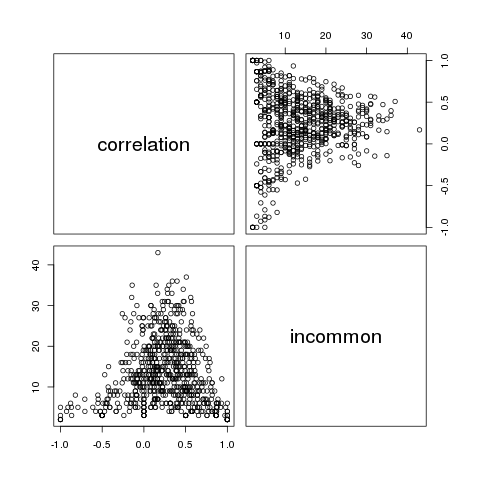

In [24]:
%%R

pairs(cor.data)

#### But I think we can do better

Increasing the number of items in common ensures that lucky similarities are weeded out. It is highly unlikely more than $5$ common ratings are a random collision.

In [35]:
%%R

cor.data.filtered <- cor.data[cor.data$incommon > 5, ]
kable(head(cor.data.filtered[ order(cor.data.filtered[,1], decreasing=TRUE), ], 25), format='rst')



===  ===========  ========
\    correlation  incommon
===  ===========  ========
728    1.0000000         6
210    0.9338430        12
871    0.9284767         6
409    0.8931977         6
71     0.8876254         7
610    0.8750000         6
710    0.8750000         6
563    0.8677218         6
329    0.8488382         9
113    0.8181818         8
157    0.8180960        11
162    0.8166667        11
536    0.8146183         9
306    0.8100926         7
721    0.8017837        10
395    0.7927069        16
789    0.7832178        12
524    0.7815552        17
2      0.7786246        14
263    0.7730207         6
549    0.7655318        15
725    0.7647059         6
629    0.7562353         9
623    0.7520710         6
90     0.7500000         7
===  ===========  ========


In [37]:
%%R

kable(head(cor.data.filtered[ order(cor.data.filtered[,1], decreasing=FALSE), ], 25), format='rst')



===  ===========  ========
\    correlation  incommon
===  ===========  ========
647   -0.8783101         6
196   -0.8212037         8
217   -0.7083333         7
677   -0.5519432         8
199   -0.5510141         6
636   -0.5477226         7
553   -0.4924101         6
214   -0.4694977        13
867   -0.4629100         6
701   -0.4472136         6
904   -0.4417261         6
657   -0.4412209         7
442   -0.4291975         7
388   -0.4285714        10
79    -0.4234152         9
935   -0.4232074        15
38    -0.4039624         8
148   -0.4002715         9
760   -0.3611576         8
255   -0.3506672         9
786   -0.3391993        11
337   -0.3299560         9
608   -0.3163585         8
782   -0.3162278         6
505   -0.2886751         9
===  ===========  ========


Now we have,

The five most correlated users to me are users:

1. 728
2. 210
3. 871
4. 409
5. 71

The five least correlated users to me are:

1. 647
2. 196
3. 217
4. 677
5. 199

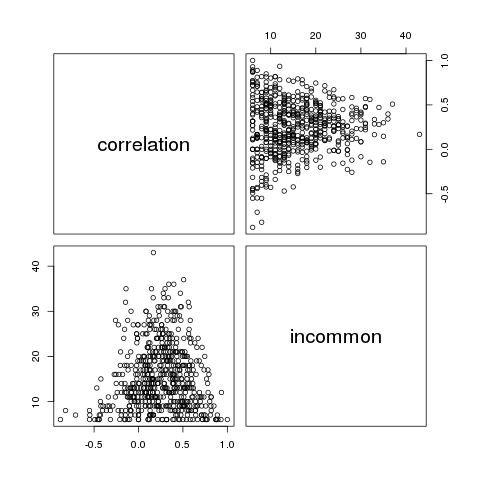

In [38]:
%%R

pairs(cor.data.filtered)

## Get top and bottom 5 recommendations

Item based filtering.

    movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation |Children's | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western |

In [26]:
%%R

head(u.item)

  movie.id                                          movie.title release.date
1        1                                     Toy Story (1995)  01-Jan-1995
2        2                                     GoldenEye (1995)  01-Jan-1995
3        3                                    Four Rooms (1995)  01-Jan-1995
4        4                                    Get Shorty (1995)  01-Jan-1995
5        5                                       Copycat (1995)  01-Jan-1995
6        6 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)  01-Jan-1995
  video.release.date
1                 NA
2                 NA
3                 NA
4                 NA
5                 NA
6                 NA
                                                      IMDB.URL unknown action
1        http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)       0      0
2          http://us.imdb.com/M/title-exact?GoldenEye%20(1995)       0      1
3       http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)       0      0
4 

In [63]:
%%R

# Keep only data to compare for item similarity
head(u.item[c(-2:-5)])

  movie.id unknown action adventure animation children comedy crime documentary
1        1       0      0         0         1        1      1     0           0
2        2       0      1         1         0        0      0     0           0
3        3       0      0         0         0        0      0     0           0
4        4       0      1         0         0        0      1     0           0
5        5       0      0         0         0        0      0     1           0
6        6       0      0         0         0        0      0     0           0
  drama fantasy film.noir horror musical mystery romance sci.fi thriller war
1     0       0         0      0       0       0       0      0        0   0
2     0       0         0      0       0       0       0      0        1   0
3     0       0         0      0       0       0       0      0        1   0
4     1       0         0      0       0       0       0      0        0   0
5     1       0         0      0       0       0       

In [69]:
%%R

# Slice only the genre data
item.data <- u.item[c(-1:-5)]
rownames <- rownames(item.data)

# Invert and replace rownames
t.item.data <- as.data.frame(t(item.data))
colnames(t.item.data) <- rownames
item.cors <- cor(t.item.data)
head(item.cors[c(1:6),c(1:6)])

           1          2           3          4          5           6
1  1.0000000 -0.1875000 -0.10206207  0.2083333 -0.1875000 -0.10206207
2 -0.1875000  1.0000000  0.54433105  0.2083333  0.2083333 -0.10206207
3 -0.1020621  0.5443311  1.00000000 -0.1020621  0.5443311 -0.05555556
4  0.2083333  0.2083333 -0.10206207  1.0000000  0.2083333  0.54433105
5 -0.1875000  0.2083333  0.54433105  0.2083333  1.0000000  0.54433105
6 -0.1020621 -0.1020621 -0.05555556  0.5443311  0.5443311  1.00000000


Now looking up item similarity is as easy as indexing a matrix `item.cors[item1.id, item2.id]`. Note that the matrix is symmetric so it is true that:

\begin{align}
A\:&=\:A^{\mathrm{T}}\\
A_{ij}\:&=\:A_{ji}
\end{align}

So now we can make recommendations by item similarity.

In [78]:
%%R

sub.me$movie.title <- u.item$movie.title[match(sub.me$item.id, u.item$movie.id)]
kable(head(sub.me), format='rst')



====  =======  ======  ==============================================
\     item.id  rating  movie.title                                   
====  =======  ======  ==============================================
536        25       4  Birdcage, The (1996)                          
1505      109       5  Mystery Science Theater 3000: The Movie (1996)
1536      118       4  Twister (1996)                                
1922      763       2  Happy Gilmore (1996)                          
2012      473       3  James and the Giant Peach (1996)              
3680      472       3  Dragonheart (1996)                            
====  =======  ======  ==============================================


In [167]:
%%R

# Recommendations based on similarity to
# Mystery Science Theater 3000


#tmp <- rbind(item.cors[109, ], as.data.frame(1:dim(item.cors)))
#tmp <- tmp[ order(tmp[1,], decreasing=TRUE) ]
#kable(head(tmp, 25), format='rst')

colname_vector <- c(1:dim(item.cors))
data <- as.data.frame(item.cors[109, ])
rownames(head(data[ order(data, decreasing=TRUE), , drop=FALSE], 10))

 [1] "109"  "152"  "171"  "204"  "577"  "728"  "1472" "13"   "25"   "26"  


Now we have a way to get the top/bottom 10 movie recommendations based on an item.

In [244]:
%%R

top.5.items <- function(i.cors, i.id, u.id) {
    user <- u.data[ u.data$user.id == u.id, ][c("item.id", "rating")]
    data <- as.data.frame(i.cors[i.id, ])
    data <- data[ -as.vector(user$item.id), , drop=FALSE ]
    data <- data[-c(i.id), , drop=FALSE] 
    rownames(head(data[ order(data, decreasing=TRUE), , drop=FALSE], 5))
}

top.5.items(item.cors, 109, 45)

[1] "152" "171" "204" "577" "728"


In [227]:
%%R

bottom.5.items <- function(i.cors, i.id, u.id) {
    user <- u.data[ u.data$user.id == u.id, ][c("item.id", "rating")]
    data <- as.data.frame(i.cors[i.id, ])
    data <- data[ -as.vector(user$item.id), , drop=FALSE ]
    data <- data[-c(i.id), , drop=FALSE]
    rownames(head(data[ order(data, decreasing=FALSE), , drop=FALSE], 5))
}

bottom.5.items(item.cors, 109, 45)

[1] "855"  "1076" "51"   "55"   "129" 


In [188]:
%%R

top.5.user <- function() {
    cor.data.filtered <- cor.data[cor.data$incommon > 5, ]
    data <- head(cor.data.filtered[ order(cor.data.filtered[,1], decreasing=TRUE), ], 5)
    rownames(data)
}

top.5.users <- top.5.user()
top.5.users

[1] "728" "210" "871" "409" "71" 


In [189]:
%%R

bottom.5.user <- function() {
    cor.data.filtered <- cor.data[cor.data$incommon > 5, ]
    data <- head(cor.data.filtered[ order(cor.data.filtered[,1], decreasing=FALSE), ], 5)
    rownames(data)
}

bottom.5.users <- bottom.5.user()
bottom.5.users

[1] "647" "196" "217" "677" "199"


In [206]:
%%R

top.5.user.items <- function(u.id, target.id) {
    # Get the User
    user <- u.data[ u.data$user.id == u.id, ][c("item.id", "rating")]
    target <- u.data[ u.data$user.id == target.id, ][c("item.id", "rating")]

    # Remove all movies in common
    items <- user[ ! (user$item.id %in% target$item.id), ]
    items <- items[ order(items[,2], decreasing=TRUE), ]
    head(items$item.id, 5)
}

top.5.user.items(728, 45)

[1] 508 117 322 678 147


In [207]:
%%R

bottom.5.user.items <- function(u.id, target.id) {
    # Get the User
    user <- u.data[ u.data$user.id == u.id, ][c("item.id", "rating")]
    target <- u.data[ u.data$user.id == target.id, ][c("item.id", "rating")]

    # Remove all movies in common
    items <- user[ ! (user$item.id %in% target$item.id), ]
    items <- items[ order(items[,2], decreasing=FALSE), ]
    head(items$item.id, 5)
}

bottom.5.user.items(728, 45)

[1] 871 546 243 124 289


In [279]:
%%R

movie.score <- list()

get.ratings <- function(u.id, i.cors) {
    
    # Get user suggestions
    top.users <- top.5.user()
    item.id <- unlist(lapply(top.users, top.5.user.items, target.id=u.id))
    
    # Get movies similar to my top 4 users top 5
    item.id <- append(item.id,
                          unlist(lapply(unique(item.id), top.5.items, 
                                        u.id=45, 
                                        i.cors=item.cors
                                       )
                                )
                         )
    
    # Get my top movies
    user <- u.data[ u.data$user.id == u.id, ][c("item.id", "rating")]
    items <- user[ order(user[,2], decreasing=TRUE), ]
    my.top.10 <- head(items$item.id, 10)
    
    # Get movies similar to my top
    item.id <- append(item.id,
                          unlist(lapply(my.top.10, top.5.items, 
                                        u.id=45, 
                                        i.cors=item.cors
                                       )
                                )
                         )
    as.data.frame(table(item.id))
}

ratings <- get.ratings(45, item.cors)
kable(head(ratings), format='rst')



=======  ====
item.id  Freq
=======  ====
1004        1
1058        1
1126        1
117         3
1219        1
125         2
=======  ====


In [277]:
%%R

get.anti.ratings <- function(u.id, i.cors) {
    
    # Get user anti-ratings
    bottom.users <- bottom.5.user()
    
    # Get user anti-suggestions
    item.id <- unlist(lapply(bottom.users, top.5.user.items, target.id=u.id))
    
    # Get movies similar to my bottom
    item.id <- append(item.id,
                          unlist(lapply(unique(item.id), top.5.items, 
                                        u.id=45, 
                                        i.cors=item.cors
                                       )
                                )
                         )
    
    # Get my bottom movies
    user <- u.data[ u.data$user.id == u.id, ][c("item.id", "rating")]
    items <- user[ order(user[,2], decreasing=FALSE), ]
    my.bottom.10 <- head(items$item.id, 10)
    
    # Get movies similar to my bottom
    item.id <- append(item.id,
                          unlist(lapply(my.bottom.10, top.5.items, 
                                        u.id=45, 
                                        i.cors=item.cors
                                       )
                                )
                         )
    as.data.frame(table(item.id))
}

a.ratings <- get.anti.ratings(45, item.cors)
kable(head(a.ratings), format='rst')



=======  ====
item.id  Freq
=======  ====
103         1
112         1
114         1
116         2
117         1
1188        1
=======  ====


In [285]:
%%R

result <- merge(x=ratings, y=a.ratings, by.x='item.id', by.y='item.id', all=T)
result[ is.na(result) ] <- 0
result$total <- (result$Freq.x - result$Freq.y)
result$movie.title <- u.item$movie.title[match(result$item.id, u.item$movie.id)]

kable(head(result[ order(result[,4], decreasing=TRUE), ]), format='rst')



===  =======  ======  ======  =====  =========================
\    item.id  Freq.x  Freq.y  total  movie.title              
===  =======  ======  ======  =====  =========================
17   159           3       0      3  Basic Instinct (1992)    
34   204           3       0      3  Back to the Future (1985)
45   291           3       0      3  Absolute Power (1997)    
48   322           3       0      3  Murder at 1600 (1997)    
69   479           3       0      3  Vertigo (1958)           
79   56            3       0      3  Pulp Fiction (1994)      
===  =======  ======  ======  =====  =========================


In [287]:
%%R

kable(head(result[ order(result[,4], decreasing=FALSE), ]), format='rst')



===  =======  ======  ======  =====  =======================================================
\    item.id  Freq.x  Freq.y  total  movie.title                                            
===  =======  ======  ======  =====  =======================================================
41   26            3       8     -5  Brothers McMullen, The (1995)                          
57   40            3       8     -5  To Wong Foo, Thanks for Everything! Julie Newmar (1995)
59   41            3       8     -5  Billy Madison (1995)                                   
60   42            3       8     -5  Clerks (1994)                                          
94   67            2       6     -4  Ace Ventura: Pet Detective (1994)                      
141  268           0       3     -3  Chasing Amy (1997)                                     
===  =======  ======  ======  =====  =======================================================
